In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [15]:
# Load the data
file_path = Path('../Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [16]:
# Create our features
X = df.drop(columns=['home_ownership','verification_status','issue_d','loan_status','pymnt_plan',])
X = pd.get_dummies(X)
X.head()
# Create our target
target = ['loan_status']
y = df.loc[:, target].copy()

In [17]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,total_bc_limit,total_il_high_credit_limit,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,29734.128558,5.572240e+04,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,26795.394232,5.095845e+04,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,100.000000,1.270000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,11600.000000,2.288000e+04,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,22100.000000,4.200000e+04,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,39300.000000,7.249900e+04,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,509400.000000,1.426964e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [18]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [19]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [20]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [21]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [22]:
# Scale the training and testing data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_train_scaled,y_train)

LogisticRegression(random_state=1)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [30]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(random_state=1)
brf.fit(X_train_scaled,y_train)


BalancedRandomForestClassifier(random_state=1)

In [31]:
# Calculated the balanced accuracy score
#balanced accuracy score
y_pred = brf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.7165031166353305

In [32]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   61,    40],
       [ 2924, 14180]])

In [33]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.60      0.83      0.04      0.71      0.49       101
   low_risk       1.00      0.83      0.60      0.91      0.71      0.51     17104

avg / total       0.99      0.83      0.61      0.90      0.71      0.51     17205



In [34]:
# List the features sorted in descending order by feature importance
importances = brf.feature_importances_
sorted(zip(brf.feature_importances_, X.columns), reverse=True)

[(0.06783529740674721, 'total_pymnt_inv'),
 (0.06416004881440014, 'total_rec_prncp'),
 (0.05513053297352986, 'last_pymnt_amnt'),
 (0.05505043652941482, 'total_rec_int'),
 (0.05397700306008273, 'total_pymnt'),
 (0.029415818360137402, 'int_rate'),
 (0.020070967636041145, 'bc_util'),
 (0.019477136566655215, 'installment'),
 (0.018502218667278615, 'mo_sin_old_il_acct'),
 (0.01824635921967758, 'total_bc_limit'),
 (0.018188174318999085, 'dti'),
 (0.01713474421921771, 'max_bal_bc'),
 (0.016937830348587733, 'out_prncp_inv'),
 (0.016932154030487666, 'mths_since_recent_inq'),
 (0.01611340923407367, 'revol_bal'),
 (0.016089498892463347, 'annual_inc'),
 (0.01601729961654851, 'bc_open_to_buy'),
 (0.015906697461010918, 'mths_since_rcnt_il'),
 (0.015757383059297466, 'tot_hi_cred_lim'),
 (0.01565129487212469, 'mo_sin_old_rev_tl_op'),
 (0.01554072271185171, 'avg_cur_bal'),
 (0.015380557369730452, 'out_prncp'),
 (0.015294521632675966, 'il_util'),
 (0.014639963702233057, 'total_il_high_credit_limit'),
 (

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

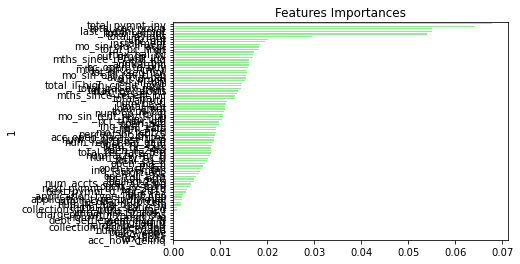

In [39]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(brf.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

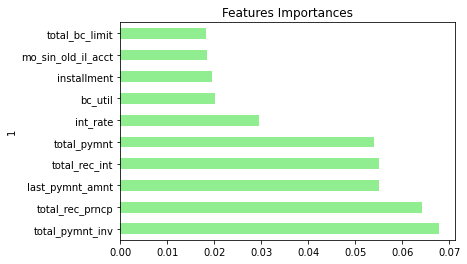

In [40]:
importance_sorted_top10 = importances_df.head(10)
importance_sorted_top10.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

### Easy Ensemble Classifier

In [35]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(random_state=1)
eec.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(random_state=1)

In [36]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.716788788911632

In [37]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   69,    32],
       [ 4269, 12835]])

In [38]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.68      0.75      0.03      0.72      0.51       101
   low_risk       1.00      0.75      0.68      0.86      0.72      0.52     17104

avg / total       0.99      0.75      0.68      0.85      0.72      0.52     17205



In [ ]:
Which model had the best balanced accuracy score?
Easy Ensemble Classifier

In [ ]:
Which model had the best recall score?
Balanced Random Forest Classifier

In [ ]:
Which model had the best geometric mean score?
Easy Ensemble Classifier

In [ ]:
What are the top three features?
total_pymnt_inv
total_rec_pmcp
last_pymnt_amnt/total_rec_int
